In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from jax.random import PRNGKey, split
from jax import config, grad
from time import time
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix, generate_sensing_matrices
from loss import create_mc_loss
from network import init_net, create_network, compute_prefactor, compress_network
from solver import train
from utils import svd, sensing_operator

In [59]:
key = PRNGKey(0)

r = 5
input_dim = 2000
output_dim = 2000
depth = 3
init_type = "orth"
init_scale = 1e-3

key, target_key = split(key)
target = generate_data(key=target_key, shape=(output_dim, input_dim), rank=r)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network()

key, observation_key = split(key)
percent_observed = 0.5
observation_matrix = generate_observation_matrix(observation_key, percent_observed, (output_dim, input_dim))
mc_loss_fn = create_mc_loss(target, observation_matrix)
e2e_loss_fn = lambda w: mc_loss_fn(network_fn(w))

In [52]:
V = compute_prefactor(init_weights, mc_loss_fn, network_fn, r)
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_init_weights = [V1_1.T] + comp_init_weights + [UL_1]
comp_network_fn = create_network()

In [57]:
num_iters = 60000
step_size = 5e2
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    loss_fn=mc_loss_fn,
    network_fn=comp_network_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=True,
    save_weights=False
)

  0%|          | 0/600 [00:00<?, ?it/s]

In [47]:
key, weight_key = split(key)
narrow_init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=2*r, depth=depth, init_type="orth", init_scale=init_scale)
narrow_network_fn = create_network()

key, observation_key = split(key)
percent_observed = 0.5
observation_matrix = generate_observation_matrix(observation_key, percent_observed, (output_dim, input_dim))
mc_loss_fn = create_mc_loss(target, observation_matrix)

In [48]:
num_iters = 200000
step_size = 5e3
narrow_weights, narrow_loss_list, narrow_time_list = train(
    init_weights=narrow_init_weights,
    loss_fn=mc_loss_fn,
    network_fn=narrow_network_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=True,
    save_weights=False
)

  0%|          | 0/2000 [00:00<?, ?it/s]

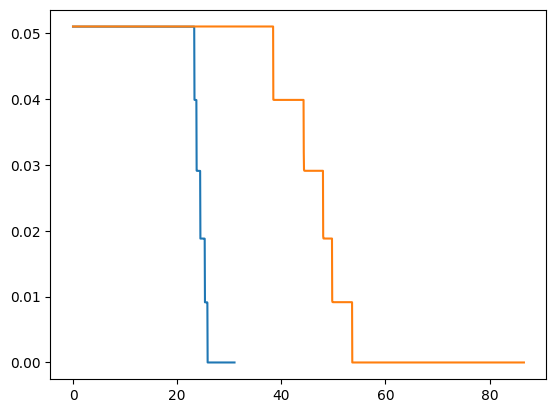

In [49]:
plt.plot(comp_time_list, comp_loss_list)
plt.plot(narrow_time_list, narrow_loss_list)

In [30]:
narrow_network_fn(narrow_weights)

Array([[ 4.03228213e-14, -8.12419865e-13, -3.32190357e-13, ...,
         6.09415554e-13,  5.25474203e-13,  6.12236165e-14],
       [ 4.48061651e-13,  7.35501138e-13,  5.59241510e-13, ...,
        -4.11393336e-13, -1.86856513e-13, -6.43852750e-13],
       [ 2.83118641e-13,  9.27121236e-13,  9.02562608e-13, ...,
         1.99134448e-13, -4.55359211e-13, -1.01408694e-12],
       ...,
       [ 8.45478251e-13, -7.41398279e-13, -3.46494317e-13, ...,
         2.86498556e-13,  8.15659388e-13, -8.63841702e-13],
       [ 1.76442040e-13,  6.35884033e-13,  6.25152222e-13, ...,
        -1.04519981e-12, -1.06518027e-12, -9.69297481e-14],
       [-9.79255638e-13,  1.76043913e-12,  1.05457460e-12, ...,
        -5.40202600e-13, -9.65817130e-13,  9.90259982e-13]],      dtype=float64)

In [31]:
comp_network_fn(comp_weights)

Array([[-0.14203799,  0.04061455, -0.30198827, ...,  0.0137861 ,
         0.46355582, -0.03380671],
       [ 0.66808283, -0.22627953,  0.82889191, ..., -0.034318  ,
        -0.18854189,  0.14257228],
       [ 0.68301225,  0.33842463, -0.38477618, ...,  0.4377542 ,
         0.3225461 ,  0.29872272],
       ...,
       [-0.49587344, -0.01472289, -0.40259145, ..., -0.00570193,
         0.62383252, -0.03189054],
       [ 0.28503207, -0.24274139,  0.43375246, ...,  0.62488122,
         0.87274332,  0.83037019],
       [ 0.69106831, -0.17179599,  0.53964267, ...,  0.20549506,
         0.10940129,  0.25655483]], dtype=float64)